In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import matplotlib.style
import os
import pickle
from functools import partial
from math import ceil
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import pandas as pd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/My Drive/EEG/EEG.machinelearing_data_BRMH.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [9]:
# function to rename
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
# rename columns
df.rename(reformat_name, axis=1, inplace=True)
# show df
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [10]:
patients_info = df.loc[:,'sex':'specific.disorder']
patients_info

,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder
0,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder
1,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder
2,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder
3,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder
4,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder
...,...,...,...,...,...,...,...
940,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control
941,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control
942,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control
943,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control


In [11]:
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
sep_col

'Unnamed: 122'

In [12]:
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

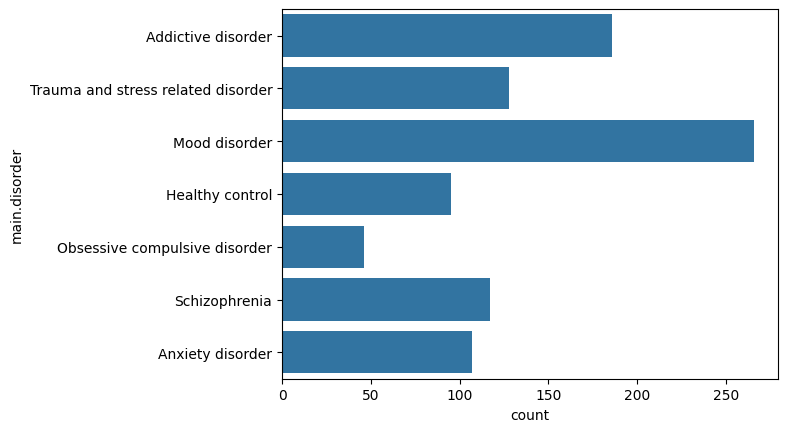

In [13]:
countplot(y='main.disorder')
plt.show()


main.disorder                       specific.disorder             
Trauma and stress related disorder  Acute stress disorder              38
                                    Adjustment disorder                38
Obsessive compulsive disorder       Obsessive compulsitve disorder     46
Anxiety disorder                    Social anxiety disorder            48
Trauma and stress related disorder  Posttraumatic stress disorder      52
Anxiety disorder                    Panic disorder                     59
Mood disorder                       Bipolar disorder                   67
Addictive disorder                  Alcohol use disorder               93
                                    Behavioral addiction disorder      93
Healthy control                     Healthy control                    95
Schizophrenia                       Schizophrenia                     117
Mood disorder                       Depressive disorder               199
dtype: int64

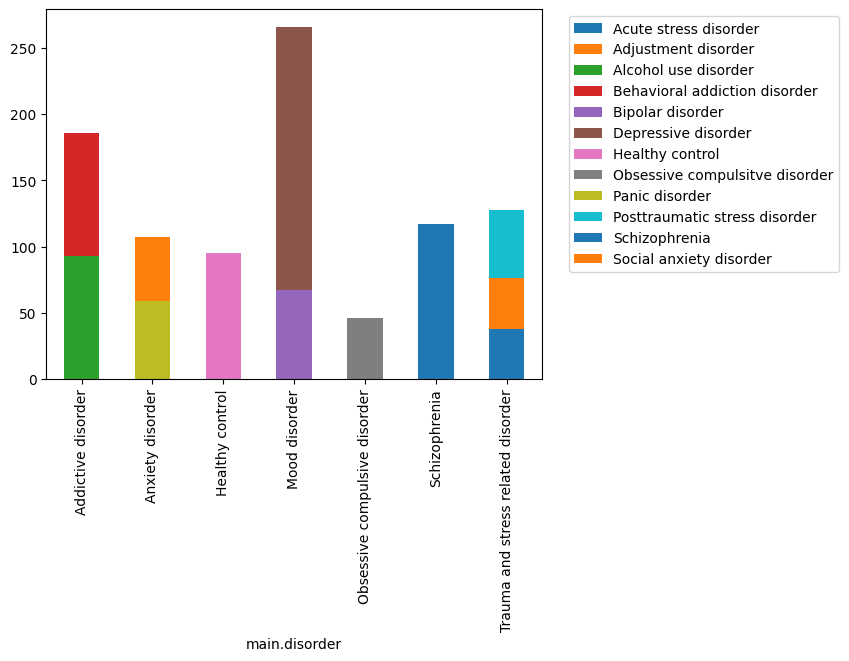

In [14]:
fig,ax = plt.subplots()
disorder_counts = df.groupby(['main.disorder', 'specific.disorder']).size()
display(disorder_counts.sort_values())
disorder_counts.unstack('specific.disorder')\
    .plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.xaxis.grid(False)
plt.show()

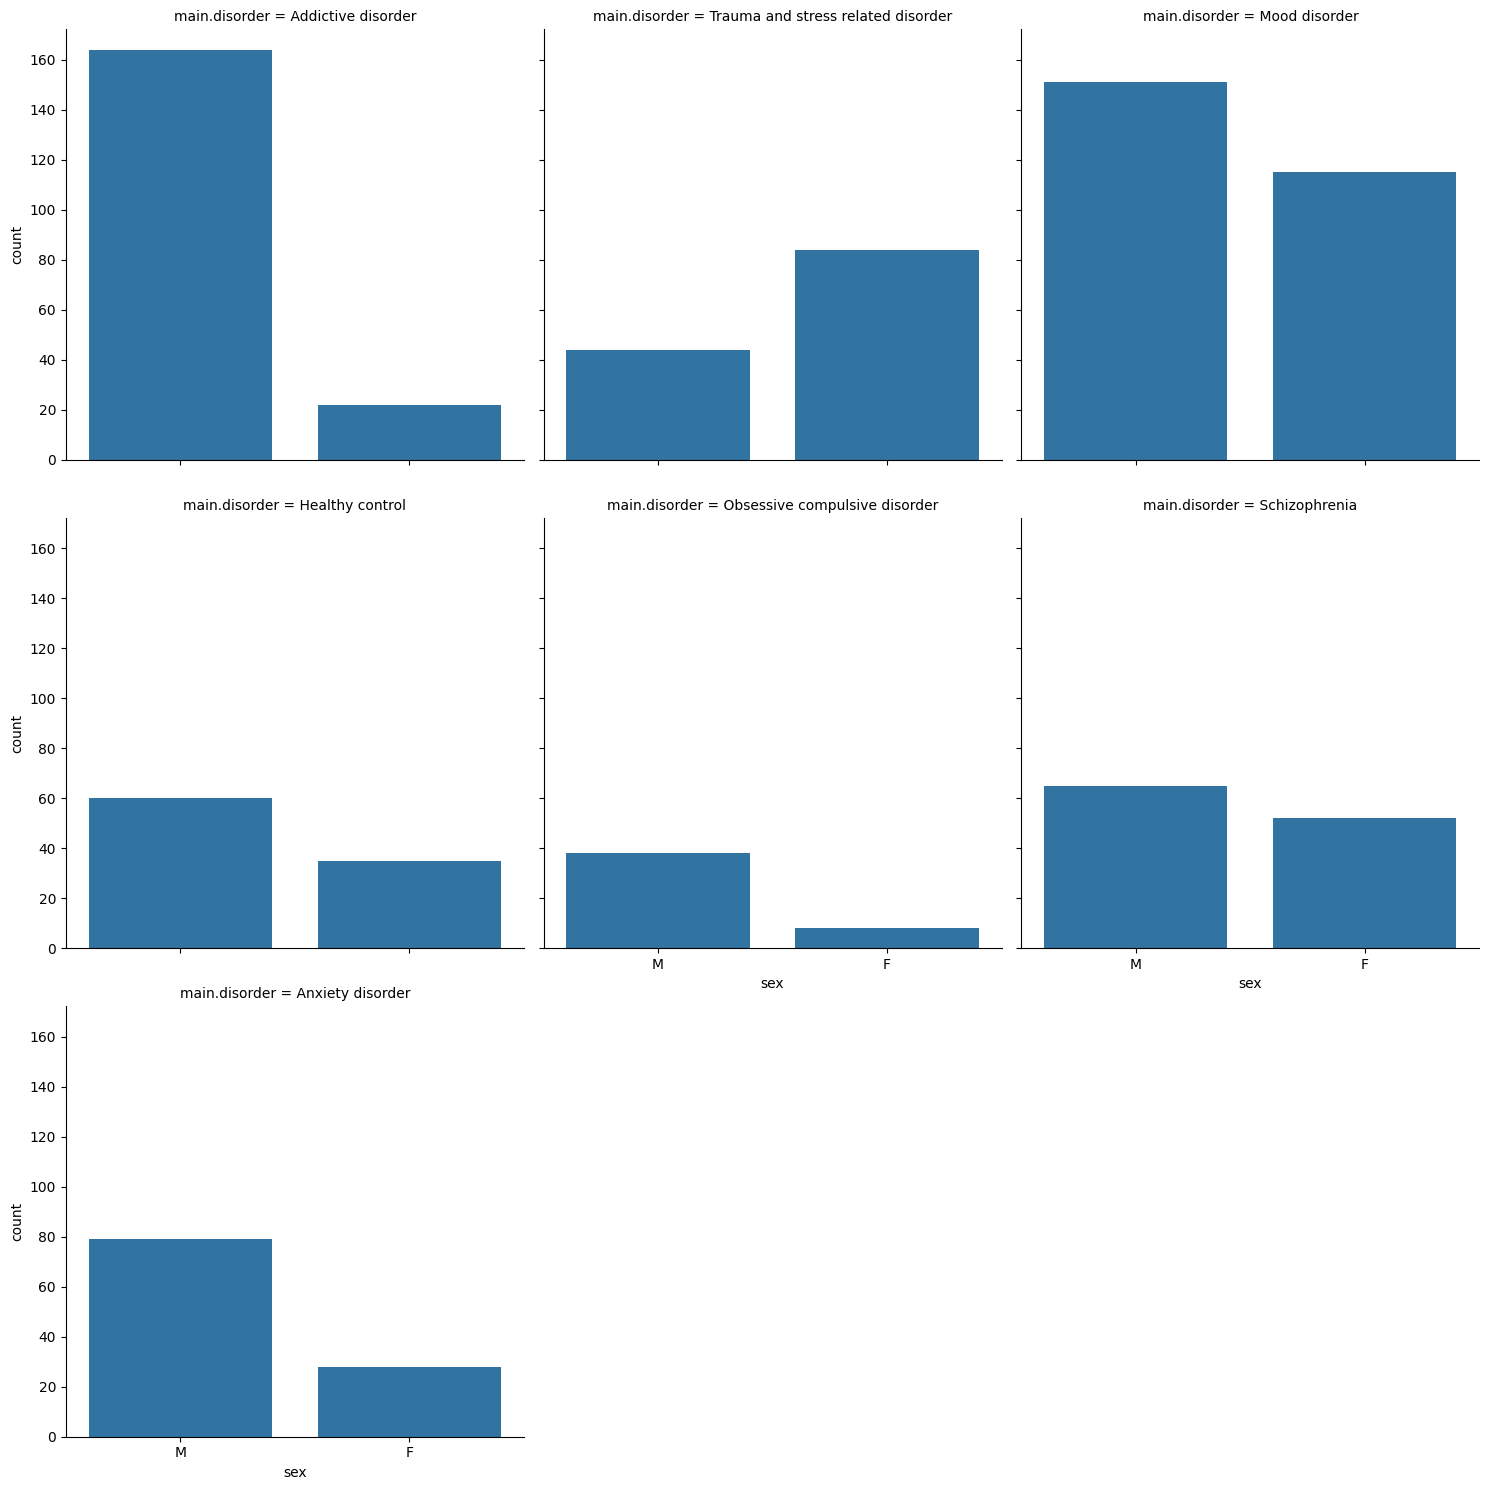

In [16]:
countplots(x='sex', col='main.disorder', col_wrap=3)
plt.show()

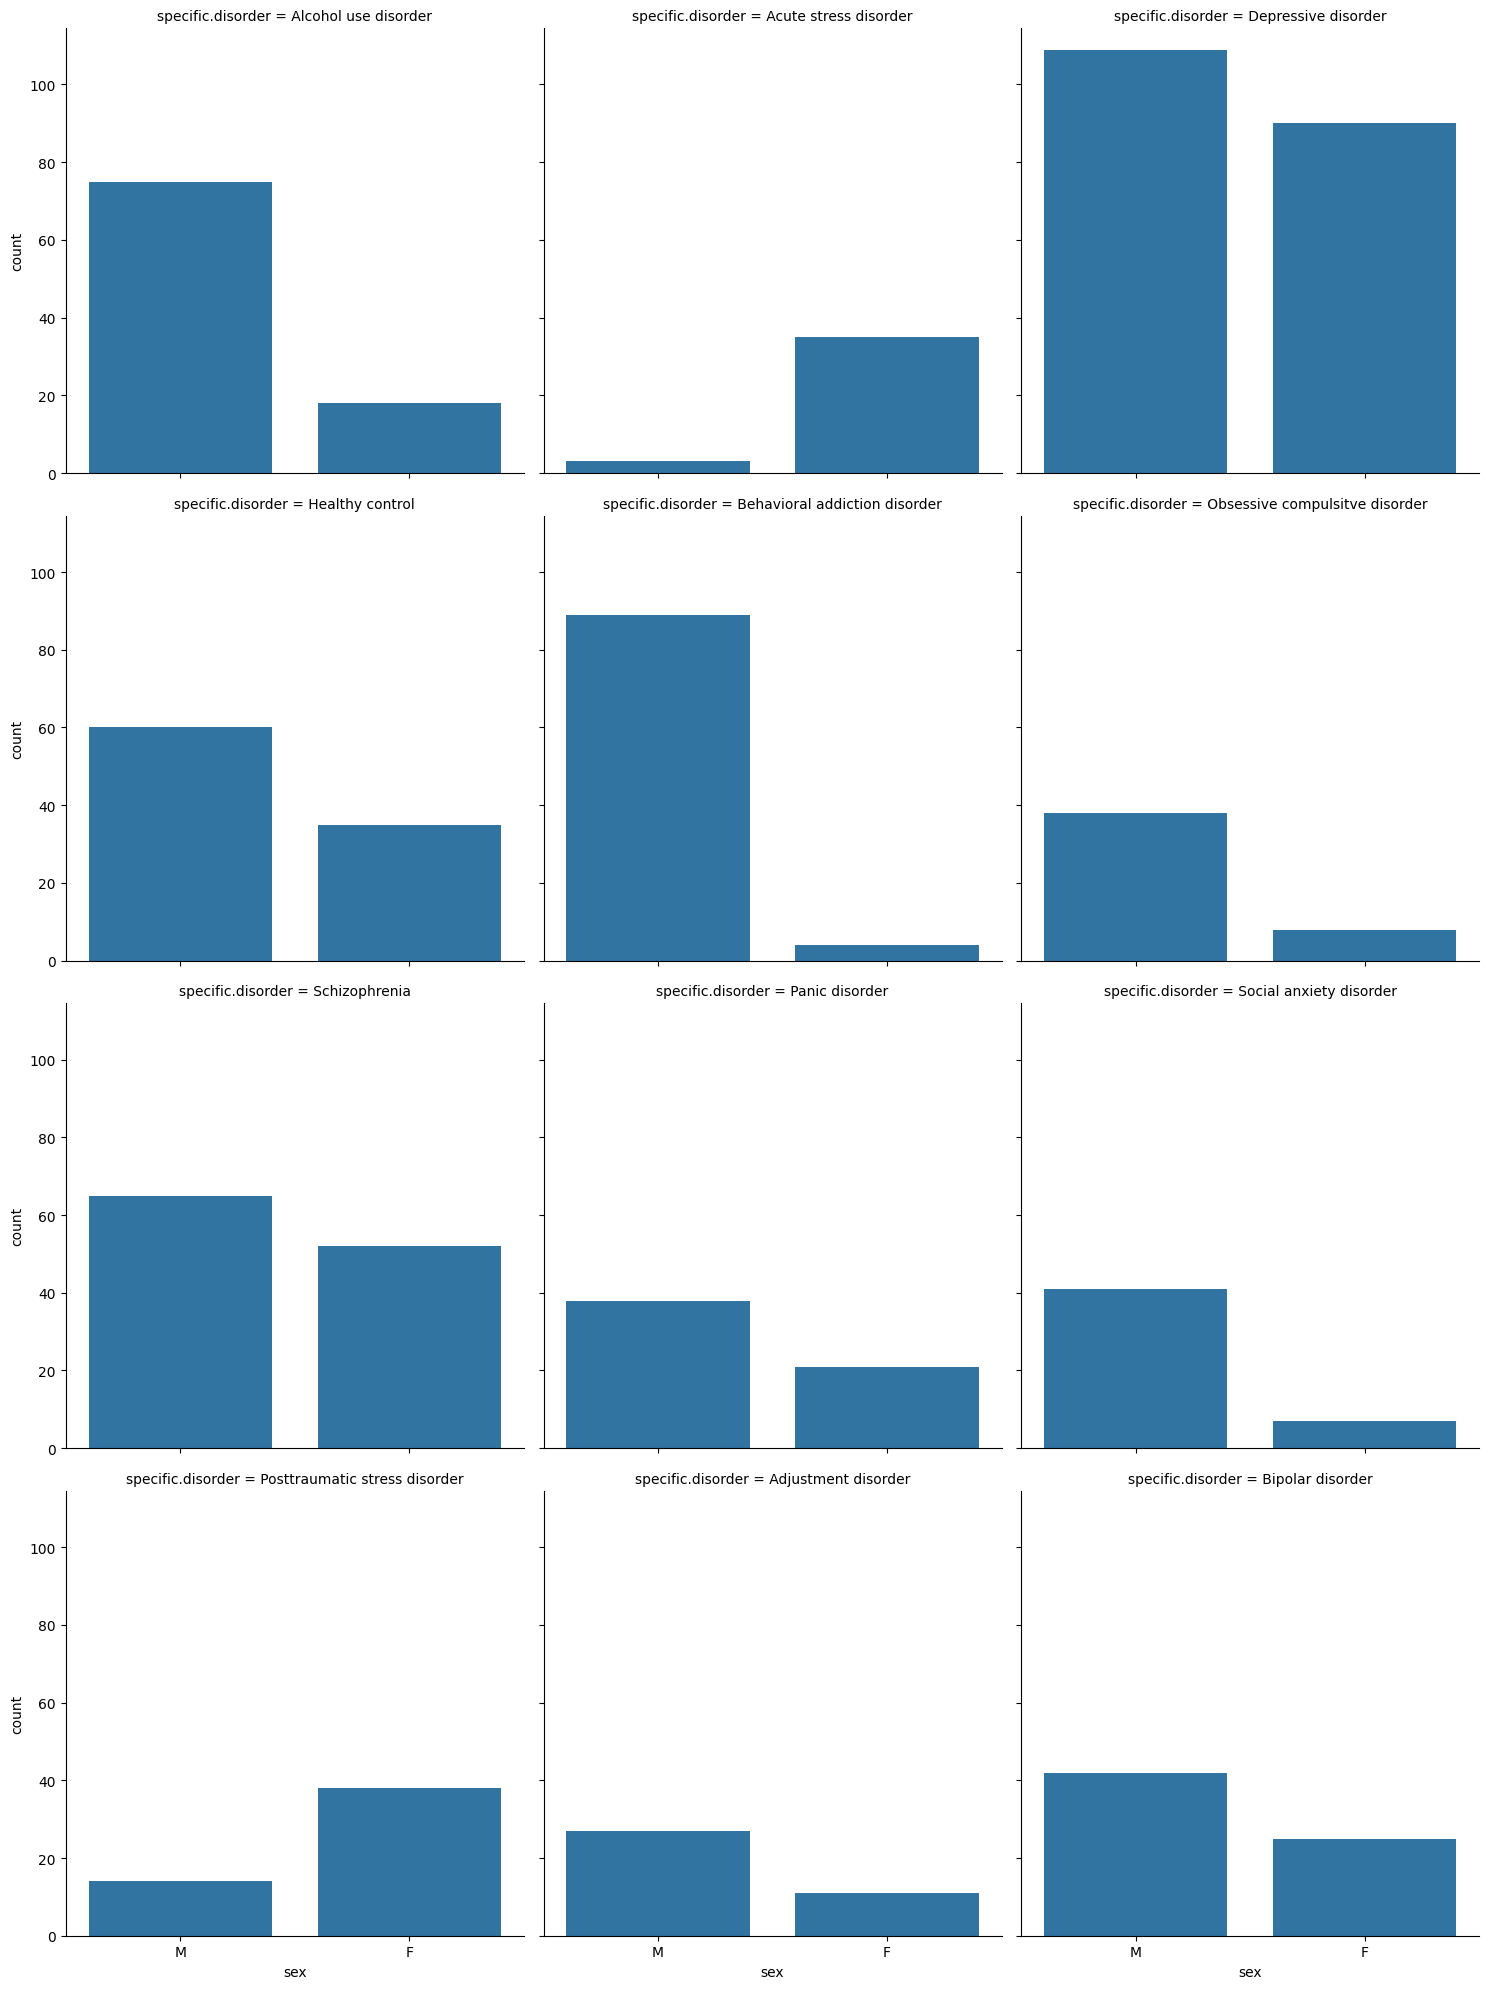

In [17]:
countplots(x='sex', col='specific.disorder', col_wrap=3)
plt.show()

In [18]:
# wide to long to make visualisations
df_long = patients_info.melt(id_vars = ['sex', 'main.disorder', 'specific.disorder'], value_vars=['age', 'education', 'IQ'])
#df_long

displot = partial(sns.displot,
                  data=df_long, kind='hist',
                  x='value', col='variable',
                  col_wrap=3, common_bins=False,
                  facet_kws={'sharex': False, 'sharey': False})

displot2 = partial(sns.displot,
                  data=patients_info, kind='hist',
                  col_wrap=3,facet_kws={'sharey': False})

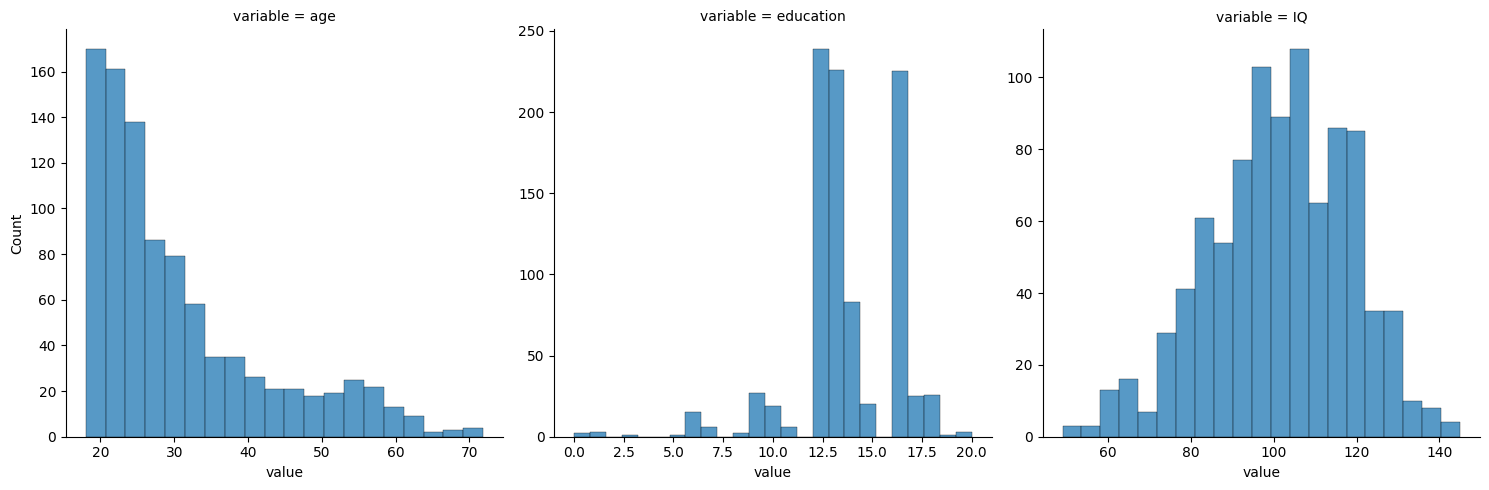

In [19]:
displot()
plt.show()

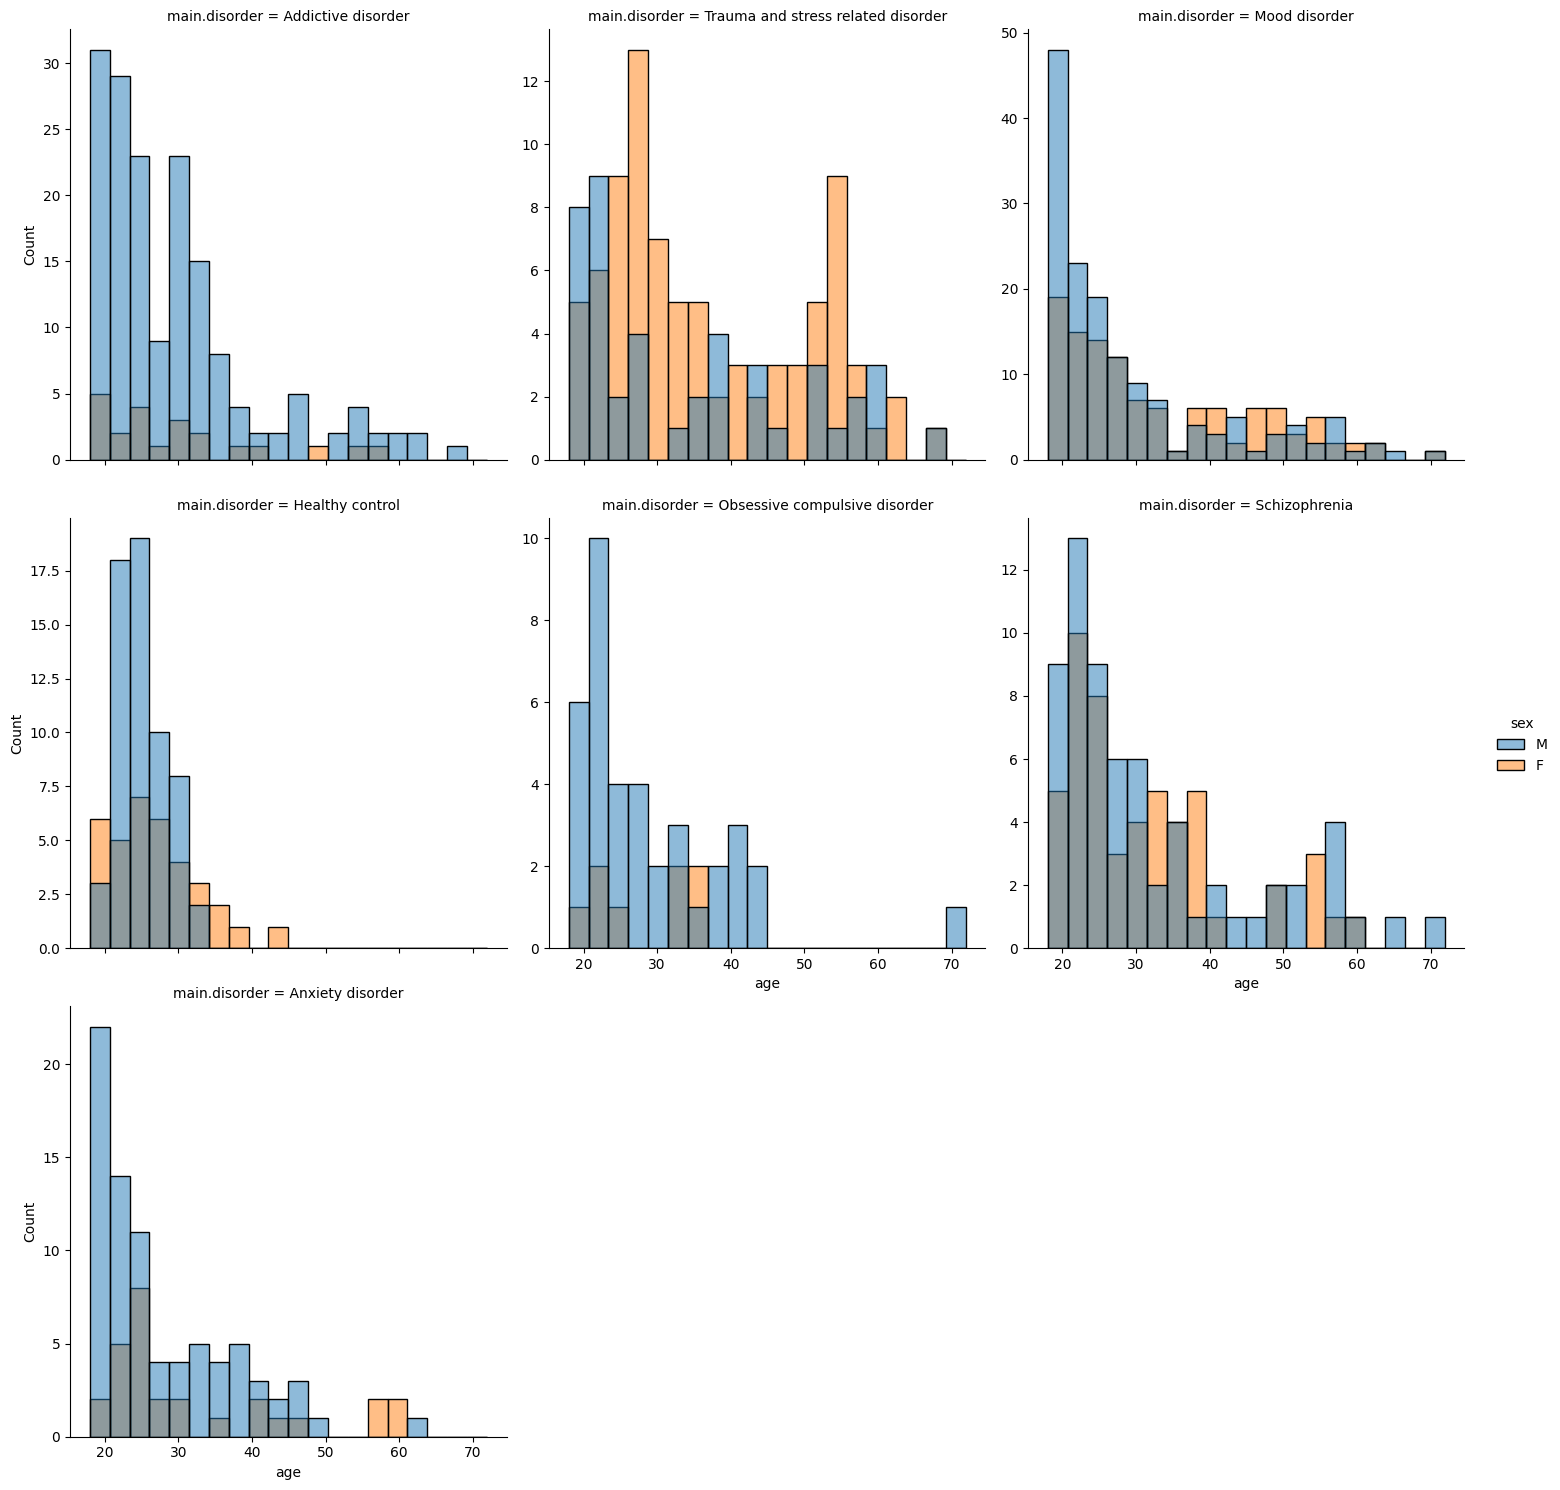

In [20]:
displot2(x='age', col='main.disorder', hue='sex')
plt.show()

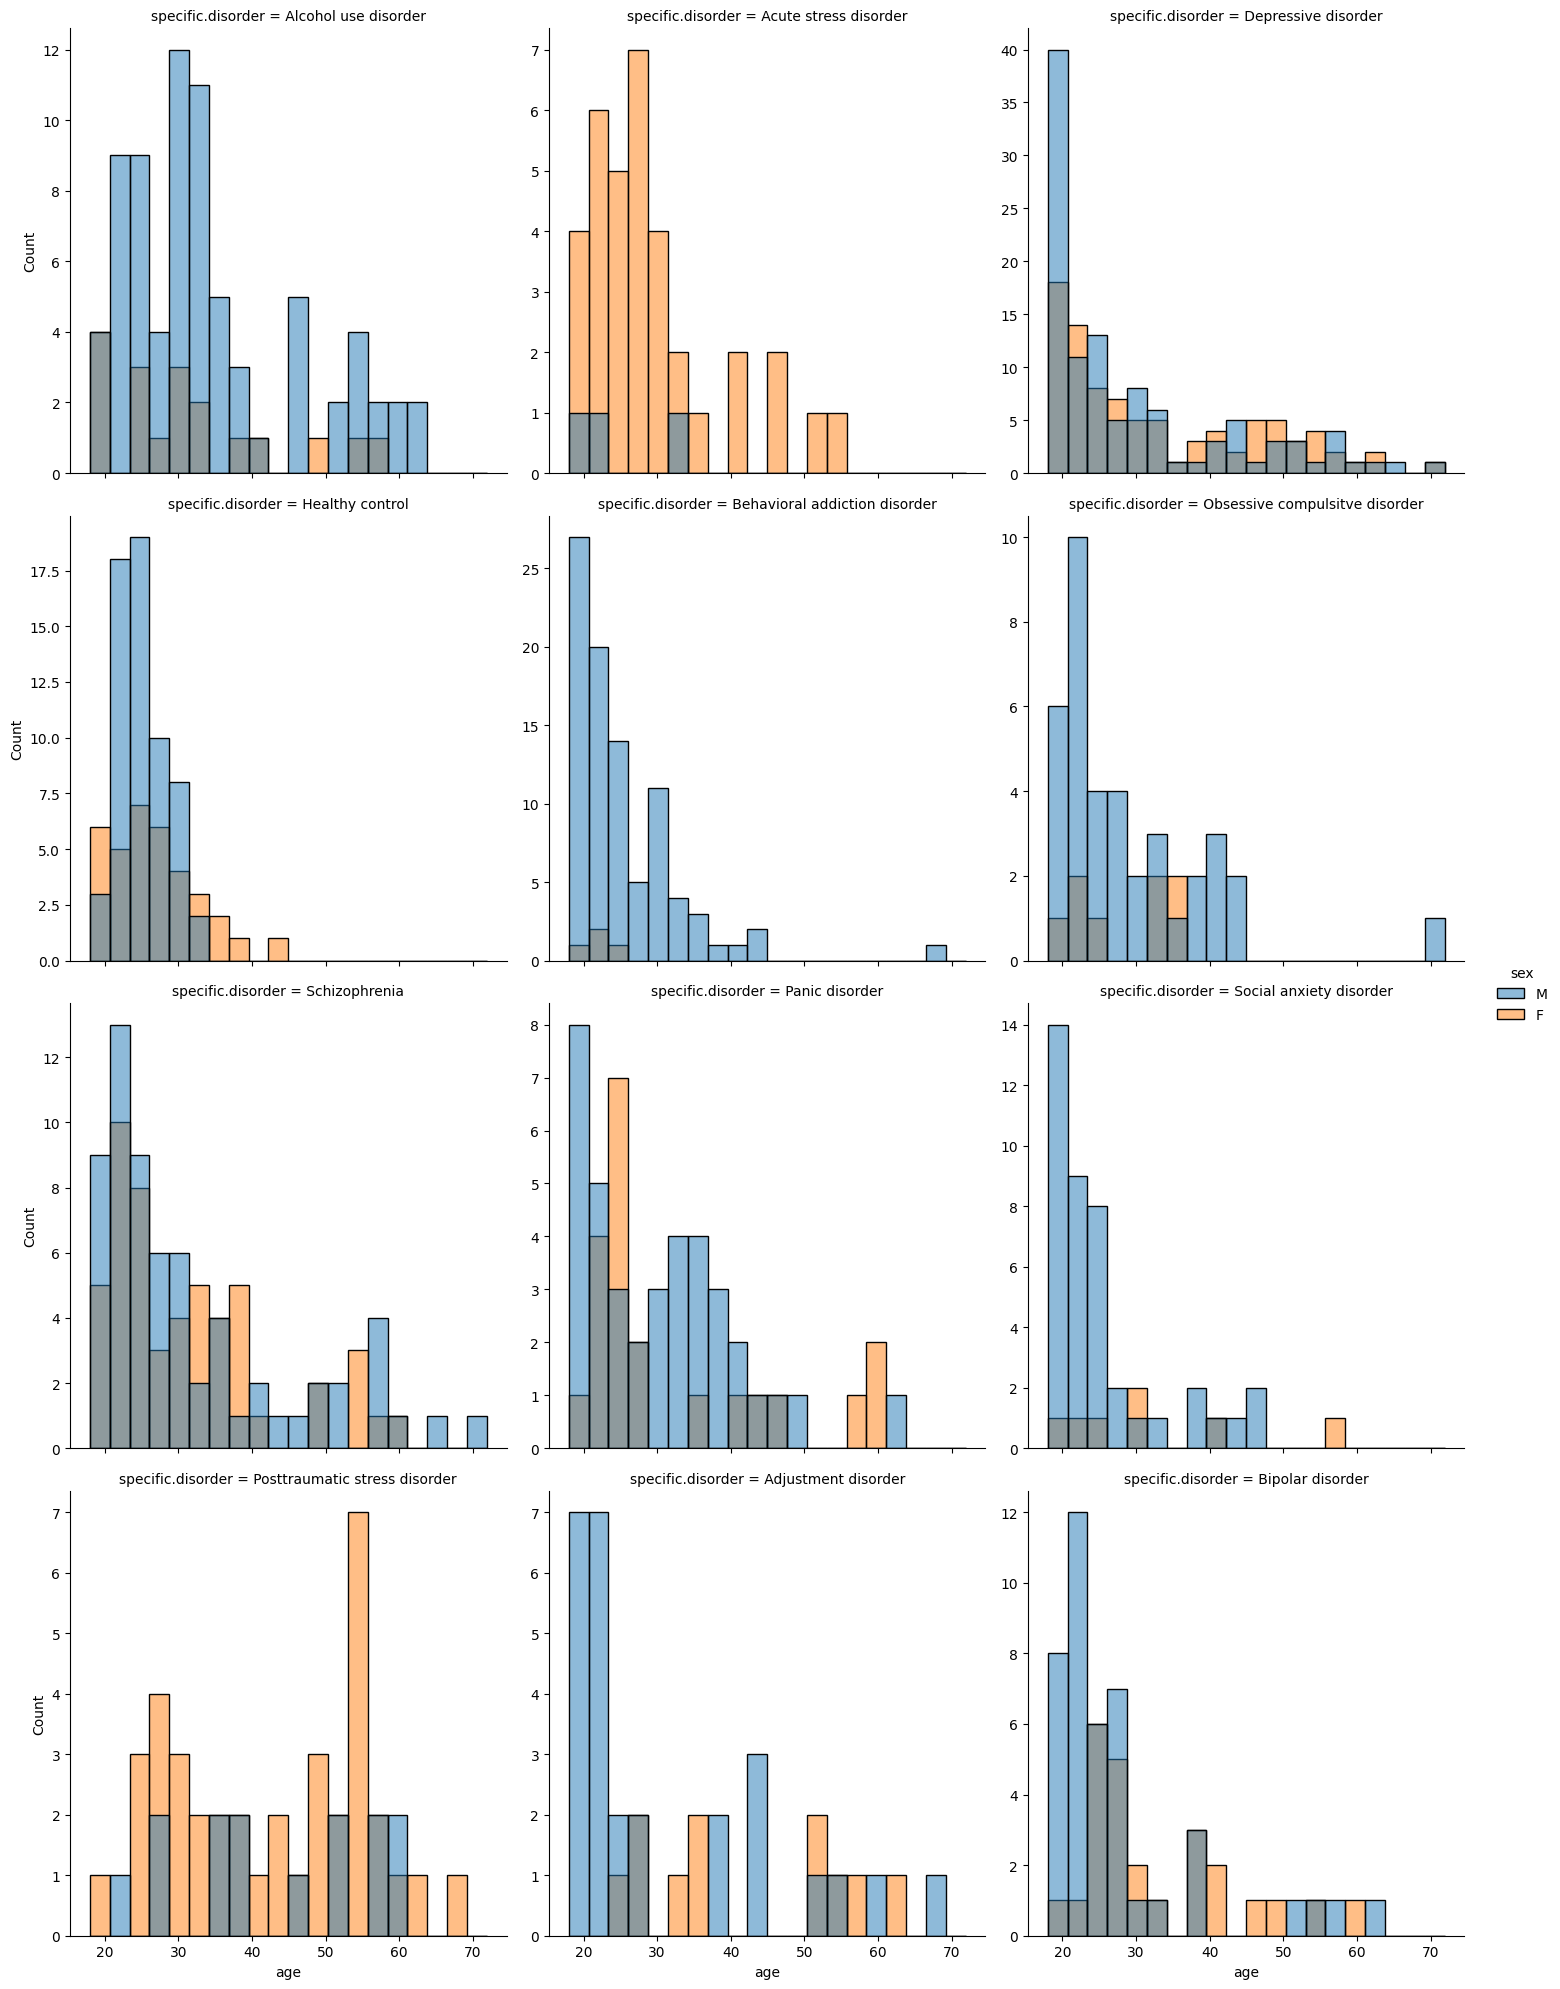

In [21]:
displot2(x='age', col='specific.disorder', hue='sex')
plt.show()

In [22]:
missing = df.isna().sum()
missing[missing > 0]

,0
education,15
IQ,13
Unnamed: 122,945


In [23]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.00,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
17,18,M,30.00,2013.9.27,NaN,86.0,Addictive disorder,Alcohol use disorder,12.443237,12.503703,...,85.080600,53.533875,62.817411,68.040950,71.834549,48.779049,80.516443,22.049743,76.277261,45.629506
21,22,M,20.00,2014.10.23,NaN,116.0,Addictive disorder,Alcohol use disorder,28.287190,22.412264,...,33.065475,24.351780,18.764173,32.610337,38.451805,20.933501,48.626712,16.258394,40.471735,24.175359
155,156,M,18.00,2013.12.7,NaN,103.0,Addictive disorder,Behavioral addiction disorder,16.548803,19.042179,...,93.825121,79.091595,83.132315,88.900783,87.508591,76.257681,89.811513,62.739950,84.729816,86.322844
173,174,M,23.00,2015.11.14,NaN,113.0,Healthy control,Healthy control,19.050158,23.277470,...,68.005720,54.685472,70.694110,62.676608,67.705314,46.667642,66.673782,29.689482,74.787580,51.039538
269,270,M,25.00,2015.9.23,NaN,85.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,6.186264,7.112847,...,72.743284,63.723838,61.257858,67.473157,77.664778,57.967084,73.898719,59.775191,81.941728,72.195171
270,271,M,34.00,2015.9.21,NaN,120.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.784872,15.922964,...,72.409132,49.265064,41.222401,68.010480,72.429188,26.188907,68.653874,18.072318,63.285321,41.822238
279,280,M,35.00,2016.6.2,NaN,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,21.524573,22.227615,...,90.934877,93.568209,94.185299,92.271775,96.445879,91.470862,96.851513,92.296182,96.209585,96.660561
280,281,M,37.00,2016.6.27,NaN,110.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,11.971083,11.374465,...,91.150863,78.359575,64.861521,74.389105,89.863923,50.322649,75.469583,49.440177,84.022887,69.921675
281,282,M,22.00,2016.6.30,NaN,107.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.516343,10.136242,...,96.419647,77.360976,95.156801,96.105427,87.746498,94.760227,97.579921,81.495805,86.770154,98.121870


In [24]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
main.disorder,,
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


In [25]:
educ_iq_medians = df[['education', 'IQ']].agg(np.nanmedian)
df[['education', 'IQ']] = df[['education', 'IQ']].fillna(educ_iq_medians)
missing = df.isna().sum()
missing[missing>0]

<ipython-input-25-07d95f514b13>:1: FutureWarning: The provided callable <function nanmedian at 0x7c3025827910> is currently using DataFrame.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  educ_iq_medians = df[['education', 'IQ']].agg(np.nanmedian)


,0
Unnamed: 122,945


In [26]:
df.to_csv('dataset.csv', index=False)

In [27]:
# Define electrode positions
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

channels = pd.DataFrame(chs).transpose()

In [28]:
def plot_eeg(levels, positions, fig, ch_names=None, cmap='Spectral_r',
             marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
        axes = fig.subplots(1, 2, gridspec_kw={'width_ratios': [12, 1]})
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes[0], names=ch_names, vlim=(vmin, vmax),
                                  cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)
    #axes[1].set_position([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = fig.colorbar(im, cax=axes[1])
    return axes

def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0, char_space=2,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth * ncols, gheight * nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # determine the absolute max
    absmax = ceil(dataset.max().max())
    # length of label in # of characters
    len_lab = len(str(absmax))
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # plot eeg
        ax = plot_eeg(levels, channels.to_numpy(), subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # adjust labels
        lendiff = len_lab - len(str(vmax))
        if lendiff != 0:
            ticks = ax[1].get_yticks()
            labs = [str(round(x)).ljust(len_lab + lendiff * (char_space - 1), ' ') for x in ticks]
            ax[1].yaxis.set_major_locator(mticker.FixedLocator(ticks))
            ax[1].set_yticklabels(labs)
        # annotate band (if needed)
        if j == 0:
            ax[0].set_ylabel(band_labels[i])
        else:
            ax[0].set_ylabel(" ")
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

In [29]:
# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
qeeg = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)

In [33]:
df_encoded = pd.get_dummies(df, columns=['sex'], drop_first=True)

# Select features and encode target
X = df_encoded.drop(['main.disorder', 'specific.disorder'], axis=1)
y = df['main.disorder']

In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split and scale the data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [35]:
# Create a custom Dataset class
class DisorderDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
train_dataset = DisorderDataset(X_train_tensor, y_train_tensor)
test_dataset = DisorderDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Calculate class weights based on the number of unique classes in y_train
num_classes = len(np.unique(y_train))  # Ensure this matches the number of unique classes
print(np.unique(y_train) )
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the neural network model with improvements
class ImprovedDisorderClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedDisorderClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, num_classes)
        self.fc7 = nn.Linear(64, num_classes)  # Make sure this matches the number of classes in the dataset
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)  # Reduced dropout

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize the model with the correct number of classes
input_size = X_train.shape[1]
model = ImprovedDisorderClassifier(input_size, num_classes)  # num_classes now matches the number of unique classes

# Use weighted cross-entropy loss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early stopping parameters
best_loss = np.inf
patience = 5
early_stop_counter = 0

# Training loop with early stopping
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0  # reset counter if we get a better model
        best_model_state = model.state_dict()  # save the best model state
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}.")
        model.load_state_dict(best_model_state)  # load the best model state
        break

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

[0 1 2 3 4 5 6]
Epoch [1/50], Loss: 1.9465
Epoch [2/50], Loss: 1.8079
Epoch [3/50], Loss: 1.6823
Epoch [4/50], Loss: 1.5431
Epoch [5/50], Loss: 1.3458
Epoch [6/50], Loss: 1.1358
Epoch [7/50], Loss: 1.0381
Epoch [8/50], Loss: 0.9202
Epoch [9/50], Loss: 0.8640
Epoch [10/50], Loss: 0.7869
Epoch [11/50], Loss: 0.6113
Epoch [12/50], Loss: 0.5027
Epoch [13/50], Loss: 0.4876
Epoch [14/50], Loss: 0.4209
Epoch [15/50], Loss: 0.3139
Epoch [16/50], Loss: 0.2797
Epoch [17/50], Loss: 0.3315
Epoch [18/50], Loss: 0.3745
Epoch [19/50], Loss: 0.3341
Epoch [20/50], Loss: 0.2801
Epoch [21/50], Loss: 0.3018
Early stopping at epoch 21.
Accuracy: 24.34%


In [36]:
# df = df.drop([sep_col, 'no.', 'eeg.date'], axis=1).copy(deep=True)

df_encoded = pd.get_dummies(df, columns=['sex'], drop_first=True)

y = df["main.disorder"] == "Healthy control"
X = df_encoded.drop(['main.disorder', 'specific.disorder'], axis=1)

In [37]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(),dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [38]:
# Create a custom Dataset class
class DisorderDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
train_dataset = DisorderDataset(X_train_tensor, y_train_tensor)
test_dataset = DisorderDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Calculate class weights based on the number of unique classes in y_train
num_classes = len(np.unique(y_train))  # Ensure this matches the number of unique classes
print(np.unique(y_train) )
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the neural network model with improvements
class ImprovedDisorderClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedDisorderClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, num_classes)
        self.fc7 = nn.Linear(64, num_classes)  # Make sure this matches the number of classes in the dataset
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)  # Reduced dropout

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize the model with the correct number of classes
input_size = X_train.shape[1]
model = ImprovedDisorderClassifier(input_size, num_classes)  # num_classes now matches the number of unique classes

# Use weighted cross-entropy loss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early stopping parameters
best_loss = np.inf
patience = 5
early_stop_counter = 0

# Training loop with early stopping
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0  # reset counter if we get a better model
        best_model_state = model.state_dict()  # save the best model state
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}.")
        model.load_state_dict(best_model_state)  # load the best model state
        break

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f'Accuracy: {100 * correct / total:.2f}%')

[False  True]
Epoch [1/50], Loss: 0.6380
Epoch [2/50], Loss: 0.5122
Epoch [3/50], Loss: 0.3578
Epoch [4/50], Loss: 0.2399
Epoch [5/50], Loss: 0.3958
Epoch [6/50], Loss: 0.2496
Epoch [7/50], Loss: 0.1691
Epoch [8/50], Loss: 0.1366
Epoch [9/50], Loss: 0.1297
Epoch [10/50], Loss: 0.1641
Epoch [11/50], Loss: 0.1586
Epoch [12/50], Loss: 0.1926
Epoch [13/50], Loss: 0.1178
Epoch [14/50], Loss: 0.0652
Epoch [15/50], Loss: 0.0971
Epoch [16/50], Loss: 0.1772
Epoch [17/50], Loss: 0.1205
Epoch [18/50], Loss: 0.0753
Epoch [19/50], Loss: 0.0425
Epoch [20/50], Loss: 0.0392
Epoch [21/50], Loss: 0.0535
Epoch [22/50], Loss: 0.1130
Epoch [23/50], Loss: 0.1404
Epoch [24/50], Loss: 0.1027
Epoch [25/50], Loss: 0.1143
Early stopping at epoch 25.
Accuracy: 87.30%


## CONCLUSION
The results of the analysis an 86% accuracy in distinguishing between a healthy and an unhealthy mind, indicating that the model was relatively effective at recognizing the presence of mental health issues. However, when it came to pinpointing the exact psychiatric disorder, the accuracy dropped significantly to 24%. This suggests that while the model can broadly detect mental health disturbances, it faces challenges in accurately identifying specific disorders. This discrepancy highlights the complexity of psychiatric conditions and suggests the need for more refined models or additional data to improve diagnostic accuracy for specific disorders.
